In [27]:
import os, shutil
import warnings
warnings.filterwarnings('ignore')
import pathlib


In [28]:
# %pip install -q -U keras-tuner


In [29]:
# os.getcwd()

In [30]:


# original_dataset_dir = '/home/kailash/VScode Python projects/tf/conv/kaggle_dataset/train'


In [31]:

base_dir = '/home/kailash/VScode Python projects/tf/conv/small_dataset/'




In [32]:
base_dir

'/home/kailash/VScode Python projects/tf/conv/small_dataset/'

### Folders for train,test,validation data ###

In [33]:
train_dir = os.path.join(base_dir,'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')


In [34]:
train_dir

'/home/kailash/VScode Python projects/tf/conv/small_dataset/train'

### Directory for cat and dog images for train test validation data ###

In [35]:
train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')

test_dogs_dir = os.path.join(test_dir, 'dogs')


#### Copy from kaggle train dataset to their respective directories ####

In [36]:
# fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(train_cats_dir, fname)
#     shutil.copyfile(src, dst)

In [37]:
# fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(validation_cats_dir, fname)
#     shutil.copyfile(src, dst)

In [38]:
# fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(test_cats_dir, fname)
#     shutil.copyfile(src, dst)

In [39]:
# fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(train_dogs_dir, fname)
#     shutil.copyfile(src, dst)

In [40]:
# fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(validation_dogs_dir, fname)
#     shutil.copyfile(src, dst)

In [41]:
# fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(test_dogs_dir, fname)
#     shutil.copyfile(src, dst)

In [42]:
import tensorflow as tf

In [43]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [44]:
import tensorflow as tf
from tensorflow import keras


In [45]:
model = tf.keras.models.Sequential()

# model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32,(3,3),padding = "same",activation="relu",input_shape=(150,150,3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3),padding = "same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 128)     

In [47]:

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4,decay=1e-6),metrics=['acc'])

In [48]:

train_dir = pathlib.Path(train_dir)

In [51]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)


In [52]:
validation_dir = pathlib.Path(validation_dir)

In [53]:
val_ds = tf.data.Dataset.list_files(str(validation_dir/'*/*'), shuffle=False)


In [55]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == ['cats','dogs']
  # Integer encode the label
  return tf.argmax(one_hot)

In [56]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [150, 150])

In [57]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [58]:
AUTOTUNE = tf.data.AUTOTUNE

In [59]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [60]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(40)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [61]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#   train_dir,
#   seed=123,
#   image_size=(150, 150),
#   batch_size=40)

In [62]:
# val_ds = tf.keras.utils.image_dataset_from_directory(
#   validation_dir,
#   seed=123,
#   image_size=(150, 150),
#   batch_size=40)

In [63]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(40, 150, 150, 3)
(40,)


2022-09-20 14:25:48.526518: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [64]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [65]:
import numpy as np

In [66]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.015869262 1.0


2022-09-20 14:25:48.987161: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [67]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [68]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("cats_dog",save_best_only=True)

In [69]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [70]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()


In [71]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, profile_batch='10, 15',histogram_freq=1)

2022-09-20 14:25:49.378796: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-09-20 14:25:49.378838: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-09-20 14:25:49.380640: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2022-09-20 14:25:49.562628: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-09-20 14:25:49.565618: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [72]:
history = model.fit(train_ds,batch_size = 40, epochs=100,validation_data=val_ds,callbacks=[early_stopping_cb,checkpoint_cb,tensorboard_cb])

Epoch 1/100


2022-09-20 14:25:50.934802: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 125.86MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-20 14:25:50.934901: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-09-20 14:25:51.664718: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2022-09-20 14:25:51.664912: E tensorflow/stream_executor/cuda/cuda_dnn.cc:398] Possibly insufficient driver version: 515.65.1
2022-09-20 14:25:51.664966: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops_fused_impl.h:601 : UNIMPLEMENTED: 

UnimplementedError: Graph execution error:

Detected at node 'sequential_1/conv2d_4/Relu' defined at (most recent call last):
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/kailash/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/kailash/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/home/kailash/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/kailash/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/kailash/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/kailash/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/kailash/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/kailash/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/kailash/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/kailash/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/kailash/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/home/kailash/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/home/kailash/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/kailash/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/kailash/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/kailash/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_106753/1264666649.py", line 1, in <module>
      history = model.fit(train_ds,batch_size = 40, epochs=100,validation_data=val_ds,callbacks=[early_stopping_cb,checkpoint_cb,tensorboard_cb])
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/kailash/anaconda3/envs/tensorflow1/lib/python3.10/site-packages/keras/backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/conv2d_4/Relu'
DNN library is not found.
	 [[{{node sequential_1/conv2d_4/Relu}}]] [Op:__inference_train_function_1596]

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

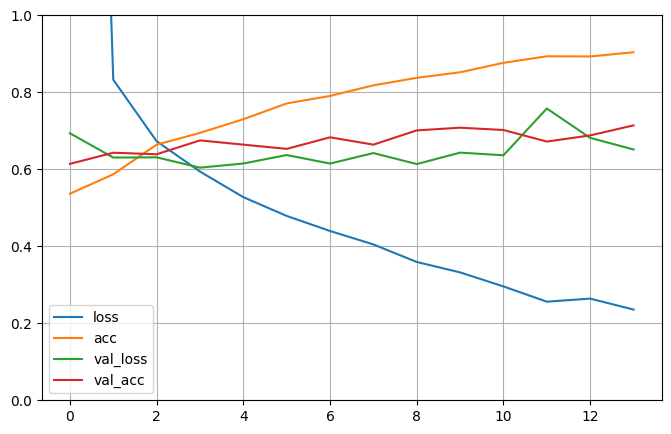

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
# model.save("cats_and_dogs")

In [ ]:
!tensorboard --bind_all --logdir=./my_logs --port=6006

/bin/bash: /home/kailash/anaconda3/envs/tensorflow1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2022-09-20 11:46:07.603804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 11:46:07.934119: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 11:46:08.970490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64: